# Logistic Regression

Last week, we discussed about **Linear Regression**, which is finding a linear "line" of best fit through our data. In the most general setting for a single response, it looks like:
$$
    y = w_0 + w_1x_1 + w_2x_2 + \cdots + w_p x_p
$$ which can be written as an inner product between two vectors:
$$
    y = \begin{pmatrix}
        1 &
        x_1&
        x_2&
        \cdots&
        x_p
    \end{pmatrix}\cdot
    \begin{pmatrix}
    w_0 \\ w_1 \\ w_2\\\vdots \\ w_p
    \end{pmatrix}
$$ 

For example, it might look like:
$$
    \text{ ( monthly expenditure ) } = w_0 + w_1\cdot\text{ ( monthly income ) } + w_2\cdot \text{ ( average savings per year ) }
$$

The linear of best fit is chosen such that:
$$
    J(w) = \frac{1}{n}\sum_{i=1}^n (y_i - X_iw)^2
$$ is minimized, where $X$ is a $\mathbb{R}^{n\times p}$ matrix of training data, $y\in\mathbb{R}^n$ the response variables, and $w\in \mathbb{R}^p$ the coefficients that determine the best fit. We also breifly demonstrated how to solve for this optimization problem, by setting the gradient $\nabla_wJ$ to 0 and computing $w*$ directly. In matrix form, the optimal parameters are given by:
$$
    w^* = (X^TX)^{-1}X^Ty
$$

In the special case where we only have one feature (namely $x$ is a $\mathbb{R}^n$ vector), the optimal solution becomes:
$$
    w^* = \frac{x^Ty}{x^Tx} = \sum_{i=1}^{n}\frac{x_i y_i}{x_i^2}
$$

In code, it can be solved as:
`w = np.linalg.solve(X.T.dot(X), X.T.dot(y))`

## Classification

Linear regression is a method for predicting numerical values by specifying a linear relationship between one response variable with one / many predictors. We can ask questions such as, E.g. How does personal credit score affect mortgage interest rate? How to predict my midterm score based on the number of hours I studied?

In other realistic settings, data might come in the form of **labels**. Common application is spam classification (whether or not an incoming email should be considered a spam) and credit default rate (whether or not a credit card holder will default).

In these settings, the output of our predictions will be categorical. Would linear regression still work well under this case?

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import torch # pytorch

In the following simulation, let `0` - `no default`, `1` - `default`.

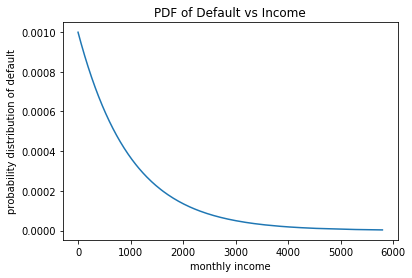

In [50]:
# set seed for reproducibility
np.random.seed(100)
# truth probability
true_p = 0.3
n = 600
# generate bernoulli data
simulated_default_data = sorted(np.random.binomial(1, true_p, n))
# generate exponential data, as x-axis
simulated_income_data = np.flip(sorted(np.random.exponential(scale=1000, size=n)))
# visualize income
plt.plot(simulated_income_data, 1*sp.stats.expon.pdf(simulated_income_data, scale=1000), label='PDF of Default');
plt.grid(); plt.xlabel('monthly income'); plt.ylabel('probability distribution of default'); 
plt.title("PDF of Default vs Income");

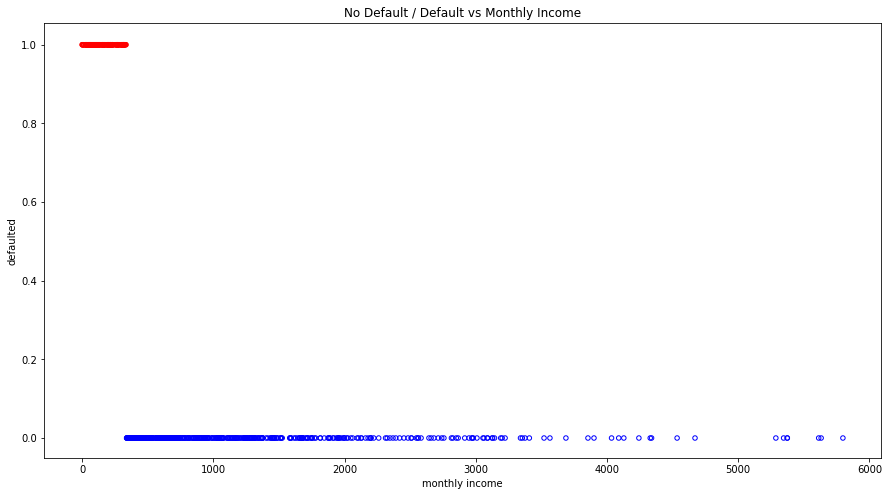

In [51]:
# shuffle the data, and generate random scatter plot
credit_data_sim = np.array(list(zip(simulated_income_data, simulated_default_data)))
default_index, _ = np.where(credit_data_sim == 1)
no_default_index, _ = np.where(credit_data_sim == 0)
sim_default = credit_data_sim[default_index]
sim_no_default = credit_data_sim[no_default_index]
plt.figure(figsize=(15, 8))
plt.scatter(sim_default[:, 0], sim_default[:, 1], marker='o',\
            s=20, facecolors='none', color="red");
plt.scatter(sim_no_default[:, 0], sim_no_default[:, 1], marker='o',\
            s=20, facecolors='none', color="blue"); plt.grid();
plt.title("No Default / Default vs Monthly Income"); 
plt.xlabel("monthly income"); plt.ylabel("defaulted");

### Linear Regression Results
When we only have 0 and 1, there is a natural way to interpret the dataset even if it is label data, as:
$$
    y_i = P(\text{ default }|X_i)
$$ as the probability of the customer defaulting given that we have seen his / her profile (in this case $X_i$).

Would linear regression work well in this case?

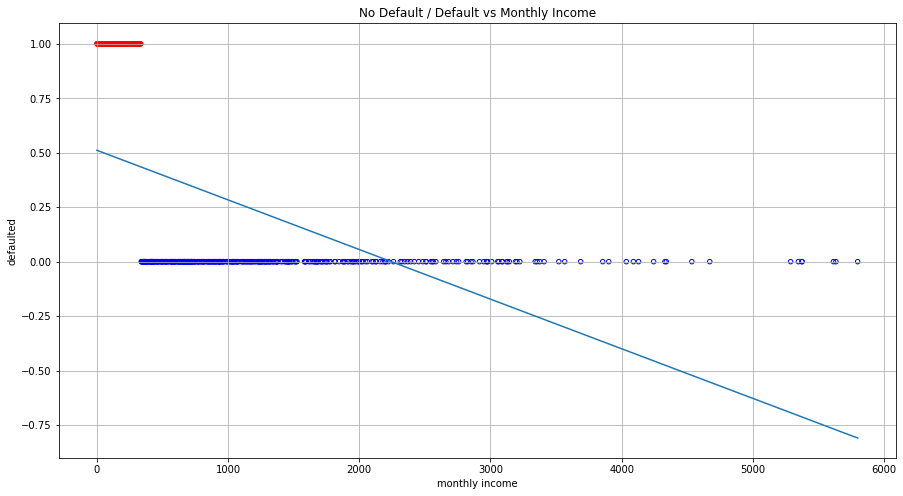

In [4]:
import sklearn
import sklearn.linear_model
X, y = credit_data_sim[:, 0].reshape(-1, 1), credit_data_sim[:, 1].reshape(-1, 1)
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(X, y)
b = predictor.intercept_
a = predictor.coef_
# plot the best linear fit with the data
plt.figure(figsize=(15, 8))
plt.scatter(sim_default[:, 0], sim_default[:, 1], marker='o',\
            s=20, facecolors='none', color="red");
plt.scatter(sim_no_default[:, 0], sim_no_default[:, 1], marker='o',\
            s=20, facecolors='none', color="blue"); plt.grid();
plt.title("No Default / Default vs Monthly Income"); 
plt.xlabel("monthly income"); plt.ylabel("defaulted");
X = X.flatten();
plt.plot(X, (a*X+b).flatten(), label='fitted probability of default');

Using this predictor, we see an issue of the ***interpretability*** for the predictions (i.e. how do we interpret predicted probabilities that are $>1$ or $<0$?)

In [5]:
# my income is 8000, what is the probability of me defaulting?
test_X_new = 8000
pred_prob = a*test_X_new + b
pred_prob[0][0]

-1.3114501745873477

Another problem we might be able to expect is that when we **cannot** naturally interpret the labels (like in the case of a binary regression). For example, when there is no ordering, we are free to attach an object any numerical value. For instance, suppose I am trying to classify images, and my labels happen to be:
$$
    y_i = 
    \begin{cases}
        1, \text{ dog }\\
        2, \text{ cat } \\
        10, \text{ banana }\\
        100, \text{ elephant }
    \end{cases}
$$ if we attempt to treat them as numerical values, we are implicitly specifying an order (that `banana` is more important than `dog` and `cat`). 

### Logistic Regression

In order to make the regression task produce interpretable probabilities, we introduce **logistic regression**:

Choose parameters $w\in\mathbb{R}^p$ such that:
$$
    J(w) = -\frac1n\sum_{i=1}^n y_i\log(s(X_iw)) + (1-y_i)\log(1-s(X_iw))
$$ is minimized. Here $s(\cdot)$ is the sigmoid function applied elementwise. Intuitively, this cost function is derived from maximizing the likelihood (or minimizing cross-entropy), which is a measure of how well our statistical model captures the correct probability distribution at hand. If you are interested in a more rigorous development, here are the links that are useful: 
* [Why maximize likelihood](https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1)
* [likelihood](https://en.wikipedia.org/wiki/Likelihood_function)
* [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy)

### The Sigmoid Function

The sigmoid function is given by:
$$
    f(x) = \frac{1}{1+e^{-x}}
$$ which has a few good properties.

(1) Smoothness: $e^{-x}$ has derivatives of all orders and strictly positive, thus $f(x)$ also has derivatives of all orders. In particular, the first order derivative is:

(1a)
$$
\frac{d}{dx}f(x) = f(x)\cdot (1-f(x))
$$

(2) $\lim_{x\rightarrow -\infty}\frac{1}{1+e^{-x}} = 0, \lim_{x\rightarrow \infty}\frac{1}{1+e^{-x}} = 1$

(3) Nondecreasing: this can be checked by noting that $f'(x)$ is always nonnegative.

(4) Using (2) and (3), we know $f: \mathbb{R} \rightarrow [0,1]$.

From Math 16B, we know that $f$ satisfies the requirements of being a CDF function. In fact, its derivative is called the [Logistic Distribution](https://en.wikipedia.org/wiki/Logistic_distribution).

(5) $\int_{\mathbb{R}}f'(x)dx = f(x)\bigg|_{-\infty}^{\infty} = 1 - 0 = 1$.

(6) $f(0) = 1/2$

The following is a visualization of the sigmoid function.

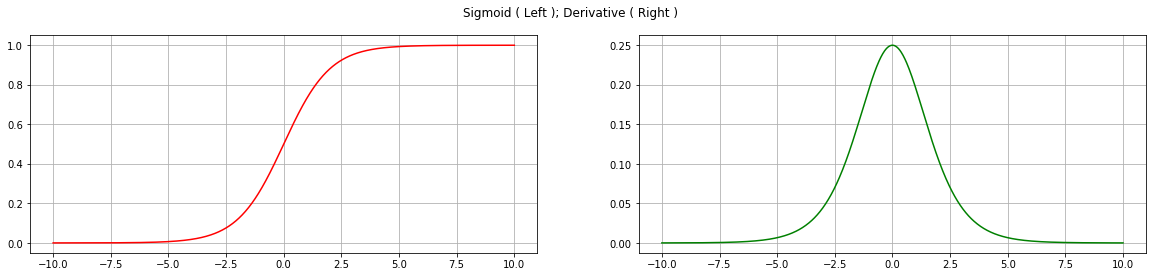

In [6]:
# grid
x = np.linspace(-10, 10, 1001)
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def df_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))
# plot
plt.rcParams['axes.grid'] = True;
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4));
fig.suptitle("Sigmoid ( Left ); Derivative ( Right )");
ax1.plot(x, sigmoid(x), color='red');
ax2.plot(x, df_sigmoid(x), color='green');

### How to Map Probabilities to Decisions

So far we introduced how logistic regression is a powerful tool in terms of predicting the probabilities of a certain event (e.g. defaulting on credit card bills) that is "most statistically likely" (maximizing likelihood) for our model. Suppose I have a customer who is predicted to have 0.65 probability of defaulting, should I label this customer as `risky`? How do we decide?

A common choice for this task is using a ***decision rule*** or a cutoff:
$$
    \begin{cases}
        \text{ output prediction 0 if }\hat{P}(y_i = 0|X_i) \le \alpha\\
        \text{ output prediction 1 if }\hat{P}(y_i = 1|X_i) > \alpha\\
    \end{cases}
$$ where $\alpha$ is our thereshold.

By the shape of the logistic function, we may be satisfied with setting $\alpha=0.5$. If my predicted probability of default is larger than that, I will declare the business as being risky; otherwise, I will be fine lending money to this customer. However, is this always a good idea? To evaluate this, we may need to consider how much we are willing to tolerate: **(a)** rate of false positives **(b)** rate of false negatives. 

A <u>**false positive**</u> is when we decide to reject the null hypothesis falsely. Similarly, a <u>**false negative**</u> is when we fail to reject the null hypothesis. 

Let's consider the following examples; also, discuss about the potential **severity** of these errors.

1. After some analysis, my financial adviser recommends that I purchase stock from X company; he claims that this is a rare opportunity to profit. The company's CEO resigned days after, in fact, there have been talks about this months ago, but my financial adviser does not stay up to date with the stock market. And I lost most of my money because the stock price plunged.

2. My financial adviser tells me to not buy stock from Y pharmaceutical, claiming said company is going out of business this month. But the company invented a cure for cancer the next week, and the stock price quadrupled. I did not benefit because of my adviser's recommendation.

3. A homeowner buys a fire alarm. A fire happened in the middle of the night, but the fire alarm does not ring.

4. A homeowner buys a fire alarm, he is unsatisfied with this product because it rings so often even when there is no fires at all.

Generally, we cannot avoid these errors entirely. But as we have seen, depending on the situation, we may have different preference of the error levels. 

We will explore this in the next section, if you are curious about a rigorous development, [this article](https://towardsdatascience.com/optimizing-logistic-regression-with-different-cutoff-values-174b6e56ea8d) is very helpful.

In the following section, we will explore a dataset regarding [Graduate School Admission](https://www.kaggle.com/mohansacharya/graduate-admissions).

Citation: ***Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019***

In [52]:
# use Kaggle API to download the dataset
! kaggle datasets list -s "graduate admission" --sort-by 'hottest' | head -10

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
mohansacharya/graduate-admissions                               Graduate Admission 2                               10KB  2018-12-28 10:07:14          60139       1538  0.7058824        
tanmoyie/us-graduate-schools-admission-parameters               US graduate school's admission parameters           4KB  2018-09-29 09:47:58           1033         18  0.8235294        
malapatiravi/graduate-school-admission-data                     Graduate school admission data                      2KB  2017-11-15 20:41:35            850          7  0.4117647        
musfiq47/us-graduate-schoolss-admission-parameters              US gra

In [53]:
! kaggle datasets files mohansacharya/graduate-admissions -v

name,size,creationDate
Admission_Predict.csv,13KB,2018-12-28 10:07:14
Admission_Predict_Ver1.1.csv,16KB,2018-12-28 10:07:14


In [54]:
# download the file in csv format
! kaggle datasets download -f Admission_Predict_Ver1.1.csv -p "./data" mohansacharya/graduate-admissions
! echo ">>> check if data is there"
! ls "./data"

Admission_Predict_Ver1.1.csv: Skipping, found more recently modified local copy (use --force to force download)
>>> check if data is there
Admission_Predict.csv        Admission_Predict_Ver1.1.csv


In [55]:
# read data in
path = "./data/"
filename = "Admission_Predict_Ver1.1.csv"
read_path = path + filename
admis = pd.read_csv(read_path)

## preprocess
def preprocess(data):
    """ preprocess DATA, a pd.DataFrame() """
    data_processed = data.copy()
    # remove NA
    data_processed = data_processed.dropna()
    # rescale GPA
    data_processed['GPA'] = data_processed['CGPA'] * (4.0 / 10)
    data_processed = data_processed.drop(columns=['CGPA'])
    # cutoff 15%
    data_processed['Admitted'] = (data_processed['Chance of Admit '] >= 0.85).astype('int')
    return data_processed
# what columns does it have
# what are data types
admis_cleaned = preprocess(admis)
admis_cleaned.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 10 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
GPA                  500 non-null float64
Admitted             500 non-null int64
dtypes: float64(4), int64(6)
memory usage: 43.0 KB


In [56]:
display(admis_cleaned.head())
print("===== number of admitted students: {}\n\n".format(admis_cleaned['Admitted'].sum()))
print("===== admission rate: {}".format(admis_cleaned['Admitted'].sum()/len(admis_cleaned['Admitted'])))
# rename
admit = admis_cleaned.copy()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,Research,Chance of Admit,GPA,Admitted
0,1,337,118,4,4.5,4.5,1,0.92,3.860,1
1,2,324,107,4,4.0,4.5,1,0.76,3.548,0
2,3,316,104,3,3.0,3.5,1,0.72,3.200,0
3,4,322,110,3,3.5,2.5,1,0.80,3.468,0
4,5,314,103,2,2.0,3.0,0,0.65,3.284,0


===== number of admitted students: 109


===== admission rate: 0.218


One of the questions posted by this dataset is how much GRE score influences admission, which is also a question you can be wondering! Let us visualize the GRE score and admissions.

In [57]:
# download test data
! kaggle datasets download -f Admission_Predict.csv -p "./data" mohansacharya/graduate-admissions

Admission_Predict.csv: Skipping, found more recently modified local copy (use --force to force download)


In [58]:
# load test data
admit_test = pd.read_csv("./data/" + "Admission_Predict.csv")
admit_test = preprocess(admit_test)
admit_test.head(5)
X_test, y_test = admit_test['GRE Score'], np.array(admit_test['Admitted']).reshape(-1, 1)
X_test_norm = np.array( (X_test - np.mean(X_test)) / np.std(X_test) ).reshape(-1, 1)

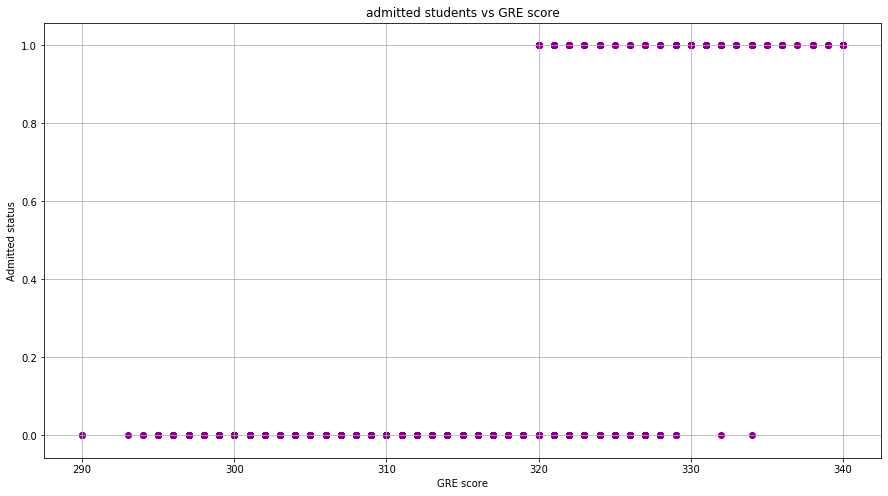

In [59]:
import seaborn as sns
# scatter plot
#plt.figure(figsize=(15, 8));
#sns.stripplot(x="GRE Score", y="Admitted", data=admit, jitter=True, facecolor="none");
# matplotlib version
# =======
plt.figure(figsize=(15, 8));
plt.scatter(admit['GRE Score'], admit["Admitted"], color="purple");
plt.title("admitted students vs GRE score"); 
plt.xlabel("GRE score"); plt.ylabel("Admitted status"); 

### Using Logistic Regression for Classification

We have 500 data points, let us use a 80-20 rule to split the data as training and validation.

In [60]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
# train test split 
from sklearn.model_selection import  train_test_split
# set random state
np.random.seed(100)
# get x y
x = admit['GRE Score']; y = admit['Admitted'];
# split data
X_train , X_val, y_train, y_val = train_test_split(x,y,test_size = 0.2);
# normalize GRE score
X_train_norm = np.array(( (X_train - np.mean(X_train)) / np.std(X_train) )).reshape(-1, 1)
X_val_norm = np.array(( (X_val - np.mean(X_val)) / np.std(X_val) )).reshape(-1, 1)

Namely we are looking for an optimal model parameter $w$ to perform:
$$
    \text{ ( Predicted Outcome ) } = \mathbf{1}(\text{Sigmoid}(w \cdot \text{ ( GRE Score ) }) \ge \alpha)
$$ where $\alpha$ is specified threshold.

It is a very good practice to try implementing everything yourself to understand the concepts. If you try to do so, please let us know; you will also need [this document](https://web.stanford.edu/~jurafsky/slp3/5.pdf) to fully understand how to optimize our parameters.

Luckily, [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is a good tool if you would like to dive into application right away. 

In [61]:
model = LogisticRegression(random_state=100, solver="newton-cg")
# evaluate accuracy
def accuracy(y_pred, y):
    return np.sum(y_pred == y) / len(y)
# fit data
model.fit(X_train_norm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=100, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

Let us evaluate our model based on what we just learned today, and test different cutoffs.

In [62]:
def logistic_decision(model, X, cutoff = 0.5):
    """ predicts labels based on specified cutoff. """
    alpha = cutoff
    all_probabilities = model.predict_proba(X)
    admission_probabilities = ...
    return (all_probabilities >= alpha).astype(int)[:, 1]

def make_report(cutoff = 0.5):
    print("===== cutoff {}%, training accuracy {}, validation accuracy {}".format(threshold*100,  \
                                accuracy(logistic_decision(model, X_train_norm, cutoff=threshold), y_train), \
                                accuracy(logistic_decision(model, X_val_norm, cutoff=threshold), y_val)))
    return None
# predict admission probabilities
threshold = 0.5
make_report(threshold)

===== cutoff 50.0%, training accuracy 0.9175, validation accuracy 0.85


To understand the model specification better, let's compute the accuracy, rate of false positive, and rate of false negative for varying cutoffs using the following formula:

$$
    \text{ ( False Positive Rate ) } = \frac{\text{False Positives}}{\text{Negatives}}
$$
$$
    \text{( False Negative Rate )} = \frac{\text{False Negatives}}{\text{Positives}}
$$

In [63]:
# helper function that evaluates prediction
def accuracy_report(model, X_val, y_val, cutoff=0.5, precision=3):
    """ using validation set, computes accuracy, false positive rate, false negative rate. """
    # reshape
    y_val_pred = logistic_decision(model, X_val, cutoff=cutoff)
    acc = accuracy(y_val_pred, y_val)
    total_pos = np.sum(y_val == 1)
    total_neg = len(y_val) - total_pos
    # number of false positives
    total_false_pos = len(y_val_pred[(y_val_pred != y_val) & (y_val == 0)])
    # number of false negatives
    total_false_neg = len(y_val_pred[(y_val_pred != y_val) & (y_val == 1)])
    # compute rates
    rfpos = total_false_pos / total_neg
    rfneg = total_false_neg / total_pos
    return np.round(acc, precision), np.round(rfpos, precision), np.round(rfneg, precision)
# test if works
accuracy_report(model, X_val_norm, y_val)

(0.85, 0.028, 0.464)

[ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a visualization that helps us choose our model sensitivity and specificity preferences, by plotting **True Positive rate** against **False Positive rate**. Recall:
$$
\text{ ( True Positive rate ) } = 1 - \text{( False Negative rate )}
$$

In [64]:
# plot ROC curve on validation set for varying cutoffs
thresholds = np.linspace(0, 1, 801)
model, X_val, y_val;
accuracy_report_data = []
for alpha in thresholds:
    accuracy_report_data.append(accuracy_report(model, X_val_norm, y_val, alpha))

In [65]:
all_accuracies = np.array([report[0] for report in accuracy_report_data])
all_rfpos = np.array([report[1] for report in accuracy_report_data])
all_rfneg = np.array([report[2] for report in accuracy_report_data])

====== best threshold found: 0.5475, yielding accuracy 0.86


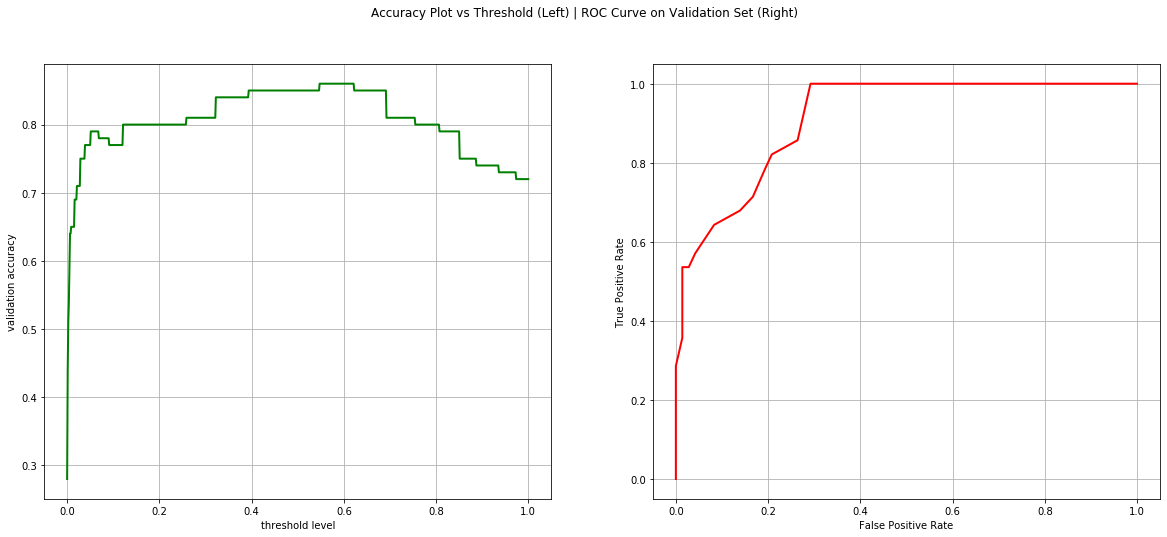

In [66]:
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8));
fig.suptitle("Accuracy Plot vs Threshold (Left) | ROC Curve on Validation Set (Right)");
ax1.plot(thresholds, all_accuracies, color="green", lw=2, label="Acc. Vs Threshold");
ax2.plot(all_rfpos, 1 - all_rfneg, color="red", lw=2, label="ROC: True Pos. vs False Pos."); 
ax1.set_xlabel("threshold level");
ax1.set_ylabel("validation accuracy");
ax2.set_xlabel("False Positive Rate");
ax2.set_ylabel("True Positive Rate"); 
print("====== best threshold found: {}, yielding accuracy {}".format(thresholds[np.argmax(all_accuracies)], \
                                                                    all_accuracies.max()))

In closing, let us look at the probabilities our model predicted on the test dataset.

In [47]:
y_test_predicted = model.predict_proba(X_test_norm)[:, 1]

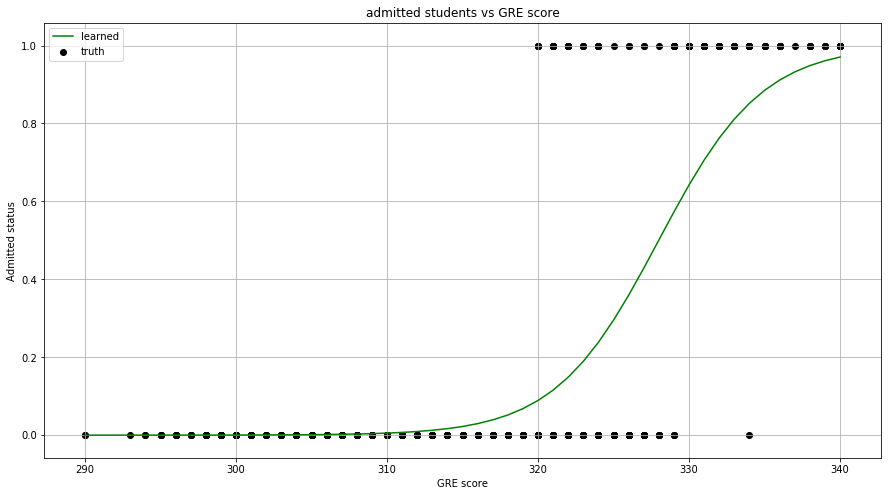

In [48]:
# plotting
# =======
plt.figure(figsize=(15, 8));
plt.plot(sorted(X_test), sorted(y_test_predicted), color="green", label="learned");
plt.scatter(X_test, y_test, color="black", label="truth");
plt.title("admitted students vs GRE score"); 
plt.xlabel("GRE score"); plt.ylabel("Admitted status"); plt.legend();